In [16]:
#python3
# Hans D. Escobar H. (hdescobarh@unal.edu.co)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr # type: ignore
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Asociación estadística entre la altura, el diametro y el número de hojas de una aracéa

# 1. Datos

Los datos corresponden a observaciones de una población de plantas de la familia _araceae_, en la Reserva Nacional Forestal Bosque de Yotoco (fecha, 26-May-2023). Datos colectados por estudiantes del curso de Fundamentos de Ecología de Poblaciones 2023-S1, Departamento de Biología. Universidad Nacional de Colombia.

In [17]:
araceae_raw_df = pd.read_csv("./aracea_altura.csv", header= 1).astype({"grupo": str})
araceae_raw_df.drop("grupo", axis=1, inplace= True)
araceae_raw_df

,altura_m,diametro_cm,numero_hojas
0,0.70,1.27,12.0
1,0.74,1.62,16.0
2,1.01,1.24,10.0
3,1.00,1.34,9.0
4,0.83,1.46,10.0
5,0.76,1.27,12.0
6,1.36,1.43,17.0
7,0.87,1.21,4.0
8,1.25,1.27,20.0
9,1.01,1.59,15.0


In [18]:
def make_boxplot(dataframe: pd.DataFrame):
    sns.set_theme(context= "paper", style="whitegrid")
    palette = sns.color_palette("Paired")
    flierprops = {'marker': 'o', 'color': "green"}
    medianprops={"color": "red"}
    color = palette[0] # type: ignore
    width = 0.6

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plt.subplots_adjust(right=1.25)

    # Altura
    sns.boxplot(dataframe["altura_m"], ax= ax1,
                flierprops = flierprops, width= width, medianprops = medianprops, color = color)
    ax1.set(xlabel="Altura (m)", xticklabels= [])

    # Diámetro
    sns.boxplot(dataframe["diametro_cm"], ax= ax2,
                flierprops = flierprops, width= width, medianprops = medianprops, color = color)
    ax2.set(xlabel="Diámetro (cm)", xticklabels= [])

    # Número de hojas
    sns.boxplot(dataframe["numero_hojas"], ax= ax3,
                flierprops = flierprops, width= width, medianprops = medianprops, color = color)
    ax3.set(xlabel="Número de hojas", xticklabels= [])

    plt.show()

## 1.1. Limpieza de datos

En el boxplot se puede observar que, bajo el criterio del 1.5·IQR (intervalo interquartilico) hay algunos outliers.

Dataset lenght:50


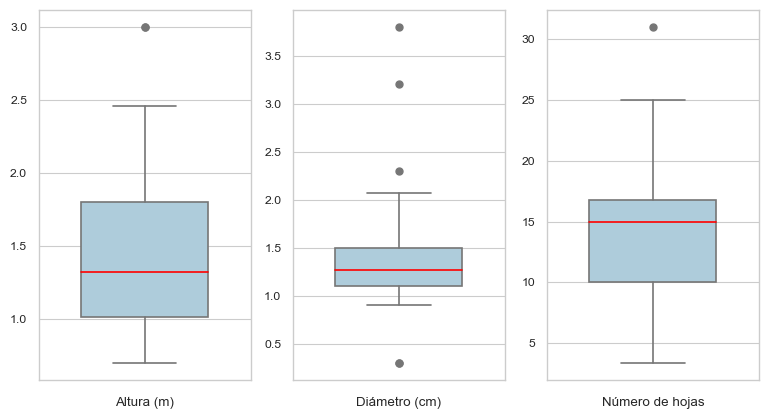

In [19]:
print("Dataset lenght:{}".format(len(araceae_raw_df)))
make_boxplot(araceae_raw_df)

Dataset lenght:43


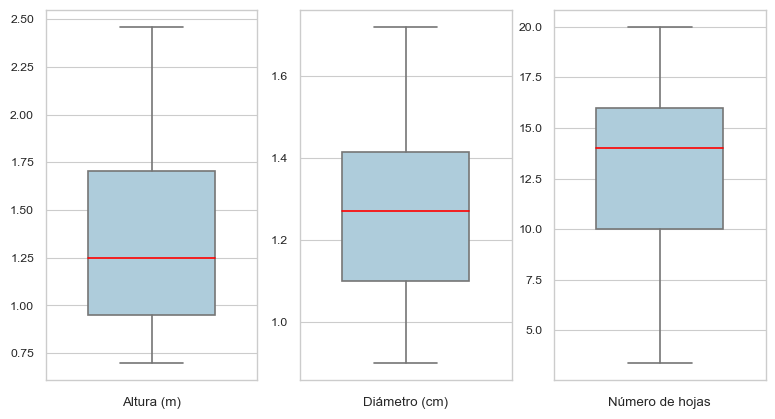

In [20]:
# Calculate upper and lower limits of +-1.5IQR interval
descriptive_df = araceae_raw_df.describe()
limit_for_outlier: dict[str, tuple[float, float]] = {col_name: (0,0) for col_name in araceae_raw_df.columns}
for col_name in limit_for_outlier:
    iqr = descriptive_df[col_name]["75%"] - descriptive_df[col_name]["25%"]
    upper_limit = descriptive_df[col_name]["75%"] + 1.5 * iqr
    lower_limit = descriptive_df[col_name]["25%"] - 1.5 * iqr
    limit_for_outlier[col_name] = (lower_limit, upper_limit)
# make a query proposition from the limits dictionary
my_query = ""
tolerance = 1e-15
for col_name, (lower_limit, upper_limit) in limit_for_outlier.items():
    my_query += f"({col_name} - {lower_limit} >= -{tolerance} & {col_name} - {upper_limit} <= {tolerance})"
my_query = my_query.replace(")(", ") & (")
# Return cleaned dataset and shows boxplot
araceae_cleaned_df = araceae_raw_df.query(my_query)
print("Dataset lenght:{}".format(len(araceae_cleaned_df)))
make_boxplot(araceae_cleaned_df)

## 2. Análisis de correlación

In [21]:
def spearman_correlation_analysis(dataframe: pd.DataFrame):
    # Realiza el análisis de correlación de Spearman, devuelve stadisticos y p-values
    rho, pvalue_uncorrected = spearmanr(dataframe, alternative="two-sided")

    # Extrae el triangulo superior sin la diagonal, y realiza corrección para multiples test
    correction_output = multipletests(pvalue_uncorrected[np.triu_indices(3, 1)], method="bonferroni")

    # Reconstruye una nueva matriz pero con los p-value corregidos
    pvalue_corrected = np.zeros((3,3))
    pvalue_corrected[np.triu_indices(3, 1)] = correction_output[1]
    pvalue_corrected[np.tril_indices(3, -1)] = correction_output[1]

    column_names = list(dataframe)
    rho_df = pd.DataFrame(rho, index = column_names, columns = column_names)
    pvalue_df = pd.DataFrame(pvalue_corrected, index = column_names, columns = column_names)
    
    return rho_df, pvalue_df


Ejemplo de como obtener el p-value mediante permutación. Recomendado cuando n es bajo.

```python
from scipy.stats import permutation_test
from scipy.stats import spearmanr 

r_spearman = lambda x: spearmanr(x,y).statistic
x = araceae_df['numero_hojas']
y = araceae_df['diametro_cm']
# Solo es necesario permutar una columna!
res_exact = permutation_test(
    (x, ), r_spearman, vectorized=False, permutation_type='pairings')
res_exact.statistic, res_exact.pvalue
```

```text
...
PermutationTestResult(statistic=0.07548153631659311, pvalue=0.603, null_distribution=array([ 0.00678922,  0.38133573,  0.09674633, ..., -0.10993681,
        0.00434025,  0.15091458]))
```

In [22]:
# Código para graficas
rename_map = {'altura_m': 'Altura (m)', 'diametro_cm': 'Diámetro (cm)', 'numero_hojas': 'Número de hojas'}

def make_heatmap(rho_df: pd.DataFrame, rename_map: dict[str, str]):
    sns.set_theme(context= "paper", style="white", palette="bright")
    mask = np.triu(np.ones_like(rho_df, dtype=bool), 1)
    f, ax = plt.subplots()#figsize=(11, 9))
    cmap = sns.color_palette("coolwarm", as_cmap=True) # sns.diverging_palette(h_neg= 15, h_pos=225, s=100, l=40, as_cmap = True)
    sns.heatmap(
        rho_df.rename(columns = rename_map, index = rename_map), mask=mask,
        annot= True, fmt=".3f", cmap=cmap,
        vmax=1, center=0, vmin=-1,
        square=True, linewidths=1, cbar_kws={"shrink": .5}, ax = ax)
    plt.show()

def make_scatterplot_histogram(
        dataframe: pd.DataFrame, rho_df: pd.DataFrame,
        pvalue_df:pd.DataFrame, rename_map: dict[str, str]):
    sns.set_theme(context= "paper", style="whitegrid", palette="muted")
    s = set_title = np.vectorize(lambda ax, rho, pval: ax.title.set_text(
        "ρ = {:.2f}\np-valor = {:.4f}".format(rho, pval)) if ax!=None else None) 
    g = sns.PairGrid(dataframe.rename(columns= rename_map), diag_sharey=False, corner= True)
    palette = sns.color_palette("Set2")
    g.map_diag(plt.hist, color = palette[0]) # type: ignore
    g.map_lower(sns.scatterplot, color = palette[1], s=50) # type: ignore
    #g.map_upper(sns.kdeplot, lw=2)
    plt.subplots_adjust(hspace = 0.6)
    set_title(g.axes,rho_df, pvalue_df)
    
    plt.show() 

### 2.1. Datos sin limpiar


In [23]:
rho_unclean, pval_corrected_unclean = spearman_correlation_analysis(araceae_raw_df)

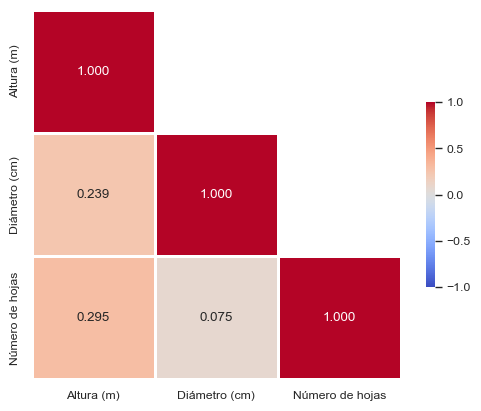

In [24]:
make_heatmap(rho_unclean, rename_map)

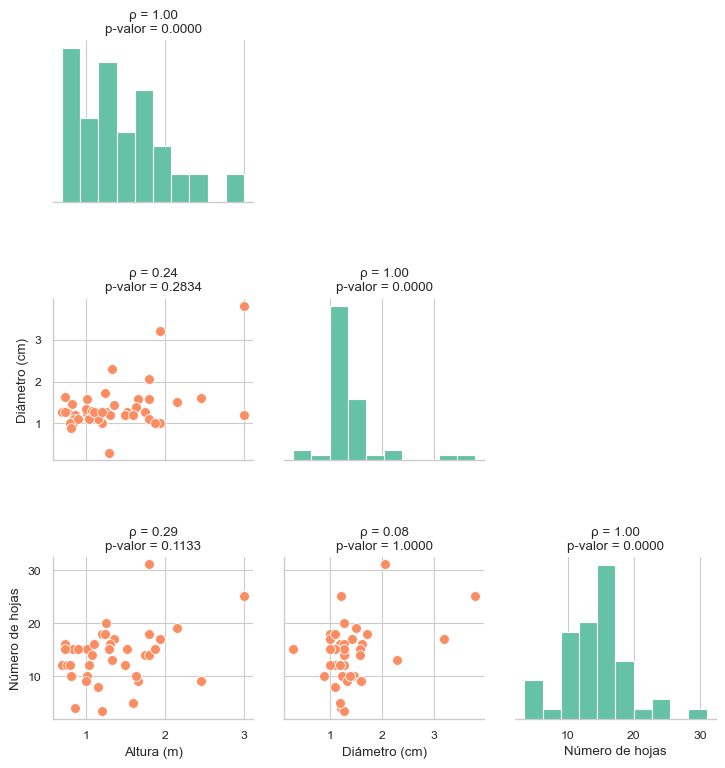

In [25]:
make_scatterplot_histogram(araceae_raw_df, rho_unclean, pval_corrected_unclean, rename_map)

### 2.2. Datos sin outliers

In [26]:
rho_clean, pval_corrected_clean = spearman_correlation_analysis(araceae_cleaned_df)

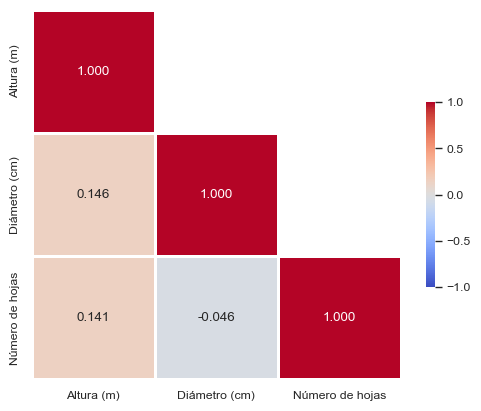

In [27]:
make_heatmap(rho_clean, rename_map)

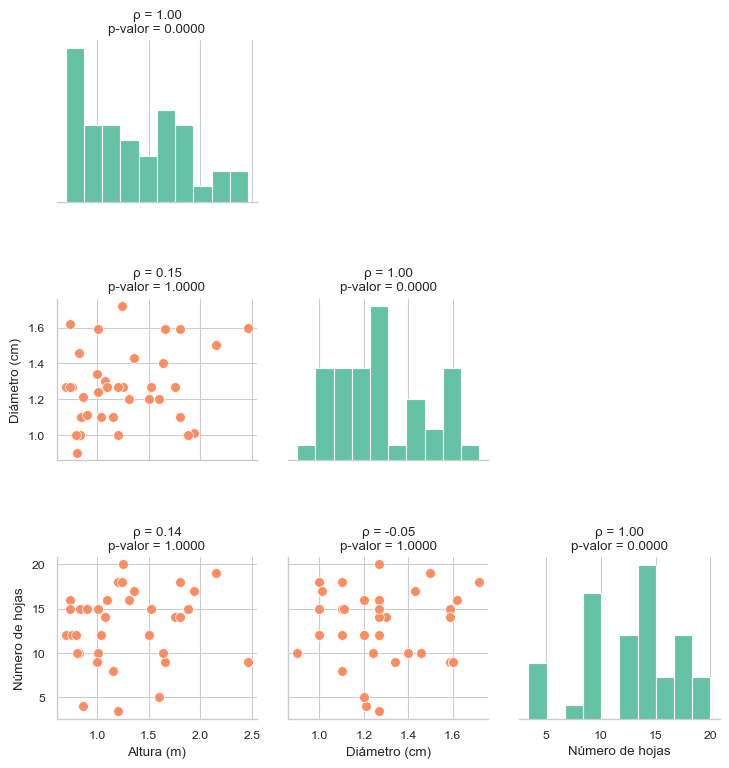

In [28]:
make_scatterplot_histogram(araceae_cleaned_df, rho_clean, pval_corrected_clean, rename_map)